# <center>Valuable Institutions: What Makes a University a Better Investment?</center>
<center>Itai Iloni</center>

## <center>Introduction</center>

One of the most important life decisions any teenager is expected to make is about their education. Will they pursue an education? What field of study would they like to be educated in? Which institution serves their interests best? At the incredibly young age of 16, high school students are expected to have an understanding of the answers to these question, and by age 18, they likely would have committed to a future.

Unsurprisingly, finances are a critical component of the decision making process when it comes to committing to an educational institution. As families make what is likely the largest financial commitment after a house, there is an important discussion of value that surrounds education.

This tutorial will guide you through an analysis of institutional data in the United States and seeks to answer two key questions:
- How can you compare the efficiency of your investment between multiple institutions?
- What features of an institution suggest it is a better investment?

## <center>Data Curation and Management </center>

### Data Sourcing
To kickstart the data science process, we first need to source some data and take a look at what is available. 

Luckily, for a topic as important as higher education, the US government keeps a substantial amount of data about the nation's educational institutions.

The data we will be analyzing is the US Department of Education's College Scorecard. The College Scorecard includes aggregrate data for thousands of postsecondary education institutions regarding institutional characteristics, enrollment, student aid, costs, and student outcomes.

### Data Curation

Before we can begin, it's important to define some key attributes (or variables) that we will use to: 
1. limit the scope of the analysis and hone in the data we think is interesting
2. distinguish the characteristics of each institution
3. provide a metric of value (or investment efficiency) associated with the institution

First, we need to know the features of our dataset, and the best way to learn is by exploring the set's data dictionary. The Department of Education provides documentation for the College Scorecard, including a data dictionary, here: https://collegescorecard.ed.gov/data/documentation/. After some exploration of the dictionary, here are the features that caught my eye.

#### Key Attributes

**Limiting Attributes (filtering variables)**:
- Highest degree awarded (`HIGHDEG = 4`) - Institution should offer a graduate degree. These institutions have the most resources available to them and are more fair to compare to each other.
- Currently operational (`CURROPER = 1`) - Institution should still be operational. We are not performing a historical analysis, so insights are most relevant about institutions that are still serving the population.
- Level of Institution (`ICLEVEL = 1`) - Institution should be a 4-year institution. This ensures that the institutions included in the analysis are comparable in terms of objective and mission.

**Institutional characteristics of interest (independent variables)**:
- Locale type (City | Suburb | Town | Rural) (`LOCALE`)
- Control (Public | Private Nonprofit | Private For-Profit) (`CONTROL`)
- Admission Rate (`ADM_RATE`)
- Enrollment (`UGDS`)

**Value Metrics (dependent variables)**:
- Average Net Price (`NPT4_PUB` or `NPT4_PRIV`) - Important note: at public institutions, this is the student cost for *in-state* students only. This does not interfere with the analysis because all students have the choice to attend an in-state public university. A measurement of value should be based off of the lower cost of attendance seen by most students.
- Median Earnings of students working and not enrolled after 10 years (from enrollment) (`MD_EARN_WNE_P10`) - Important note: this statistic includes the earnings of students who did not complete their education, but the statistic is unlikely to be affected because it is a median.

For the purpose of our analysis, we need to create a normalized measurement of value. To accomplish this, we will define a new metric called investment-earnings equivalent (IEE). IEE will be the break-even point between cost of attendance and earnings. In other words, this is the ratio between 4 years of the average net annual price (ANP) and median earnings at 10 years after enrollment (ME). $$IEE = \frac{4*ANP}{ME}$$

This is a relativistic metric that is most useful in providing a standardized comparison of institutions to each other. In essence, it describes the number of years it takes for the student to recoup the cost of attending that institution or in other terms, the return on investment. In future analyses and comparisons, it should be noted that a *lower* IEE indicates that an institution is a more valuable investment than a higher IEE institution. This metric does **not** account for living expenses and tax costs, and therefore should not be confused with the student's debt repayment period. For example if an institutions's ANP is \$30,000, and the ME is \$55,000, then $IEE = \frac{4*30,000}{55,000} = 2.18$. That being the educational investment required to attend the institution is equivalent to *2.18 years of work earnings* after enrollment.

### Data Management

Let's import the data into our workspace and get started. We will be using pandas dataframe's to manipulate our data.

The dataset we will be using is available here: https://collegescorecard.ed.gov/data/. On the website, download the data titled "Most Recent Institution-Level Data".

In [1]:
import pandas as pd

In [2]:
# Import institution-level data for postsecondary education
inst_level = pd.read_csv('data/Most-Recent-Cohorts-Institution.csv', low_memory=False)

Now that we have the data in a workable format, it's time to begin our preliminary manipulations by applying the limiting attributes detailed above.

In [3]:
print('Before dropping: ' + str(inst_level['UNITID'].count()))
# Filter entries to currently operational institutions
inst_level = inst_level.loc[inst_level['CURROPER'] == 1]

# Filter entries to graduate-degree offering institutions
inst_level = inst_level.loc[inst_level['HIGHDEG'] == 4]

# Filter entries to 4-year institutions
inst_level = inst_level.loc[inst_level['ICLEVEL'] == 1]
print('After dropping: ' + str(inst_level['UNITID'].count()))

Before dropping: 6662
After dropping: 1957


**Calculating IEE for all institutions**:  
Before we continue on to exploring our data, we should calculate the IEE for all institutions. We will be using these values often in the coming analyses, so it would be much more efficient to calculate them a single time now and use the pre-calculated values in the future.

Since our value metric is derived from average net price data and median earnings data, we need to remove any observations in the dataset that don't have that data available. Sometimes dropping missing data from the set can introduce bias to the statistical analysis, but the lack of available data for these institutions makes it impossible to analyze them. This is one of the limitations of this data analysis, as it's not feasible to know exactly why any specific piece of data is missing.

In [4]:
# Permanently drop any institution that doesn't have average net price or median earnings data.
print('Before dropping: ' + str(inst_level['UNITID'].count()))
inst_level = inst_level.dropna(subset='MD_EARN_WNE_P10')
inst_level = inst_level.dropna(subset=['NPT4_PUB', 'NPT4_PRIV'], thresh=1)
print('After dropping: ' + str(inst_level['UNITID'].count()))

# Add an empty IEE column to the dataset
inst_level['IEE'] = 0.0

# Calculate IEE for each institution and add it to the data entry.
for inst in inst_level.iterrows():
    if inst[1]['CONTROL'] == 1:
        inst_level.at[inst[0], 'IEE'] = float(4*inst[1]['NPT4_PUB'] / inst[1]['MD_EARN_WNE_P10'])
    else:
        inst_level.at[inst[0], 'IEE'] = float(4*inst[1]['NPT4_PRIV'] / inst[1]['MD_EARN_WNE_P10'])

Before dropping: 1957
After dropping: 1466


## <center>Exploratory Data Analysis</center>

We've narrowed down our dataset considerably to the institutions we believe are worth comparison, so now it's time to begin exploring the remaining data. We will be making extensive use of matplotlib to visualize our data.

In [5]:
import matplotlib.pyplot as plt

Let's start by exploring relationships between our independent variables and our IEE value metric:
- IEE vs. Locale
- IEE vs. Control
- IEE vs. Admission Rate
- IEE vs. Enrollment

### IEE vs. Institution Locale

We'll plot the IEE of each institution as a function of the institution's locale. The locale can be either city, suburb, town, or rural. An appropriate plot to visualize this relationship would be a violin plot that can show centrality, minimums, maximums, and distribution for each locale on the same plot.

In [6]:
# Aggregate data for each locale
inst_locales = [[],[],[],[]] # array with an array for each locale
for inst in inst_level.iterrows():
    # City locale
    if inst[1]['LOCALE'] >= 11 and inst[1]['LOCALE'] <= 13:
        inst_locales[0].append(inst[1]['IEE'])

    # Suburb locale
    elif inst[1]['LOCALE'] >= 21 and inst[1]['LOCALE'] <= 23:
        inst_locales[1].append(inst[1]['IEE'])

    # Town locale
    elif inst[1]['LOCALE'] >= 31 and inst[1]['LOCALE'] <= 33:
        inst_locales[2].append(inst[1]['IEE'])

    # Rural locale
    else: # inst[1]['LOCALE'] >= 41 and inst[1]['LOCALE'] <= 43
        inst_locales[3].append(inst[1]['IEE'])

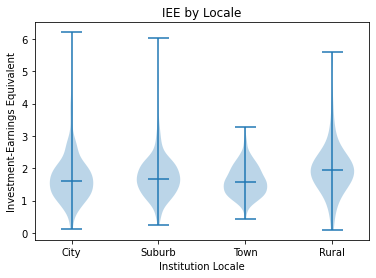

In [7]:
# Set up plot
plt.figure()
plt.title('IEE by Locale')
plt.xlabel('Institution Locale')
plt.ylabel('Investment-Earnings Equivalent')

# Set up locale labels
locales = ['City', 'Suburb', 'Town', 'Rural']
locales_pos = range(1,5)
plt.xticks(locales_pos, locales)

plt.violinplot(inst_locales, locales_pos, showmedians=True)
print()

This plot shows that the IEE for each locale is pretty similar. All locales have IEEs centered between 1.5 and 2. Cities and suburbs have high outlier institutions. All 4 locales have mostly symmetric unimodal distributions that slightly skew upwards. The distribution of rural institutions is a bit wider than the rest, but it also has the lowest sample size. Shown below are the number of institutions in each locale. The association between IEE and locale is not worth further investigation. 

In [8]:
# Number of institutions per locale
print('City institutions: ' + str(len(inst_locales[0])))
print('Suburb institutions: ' + str(len(inst_locales[1])))
print('Town institutions: ' + str(len(inst_locales[2])))
print('Rural institutions: ' + str(len(inst_locales[3])))

City institutions: 758
Suburb institutions: 362
Town institutions: 272
Rural institutions: 74


### IEE by Institution Control

Next, we'll plot the IEE of each institution as a function of the institution's control type. The control type can be either public, private nonprofit, or private for-profit. We can use a violin plot again to visualize this relationship.

In [9]:
# Aggregate data for each control type
inst_controls = [[],[],[]] # array with an array for each locale
for inst in inst_level.iterrows():
    # Public control
    if inst[1]['CONTROL'] == 1:
        inst_controls[0].append(inst[1]['IEE'])

    # Private Nonprofit control
    elif inst[1]['CONTROL'] == 2:
        inst_controls[1].append(inst[1]['IEE'])

    # Private For-profit control
    else: # inst[1]['CONTROL'] == 3
        inst_controls[2].append(inst[1]['IEE'])

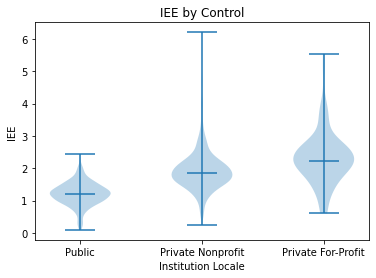

In [10]:
# Set up plot
plt.figure()
plt.title('IEE by Control')
plt.xlabel('Institution Locale')
plt.ylabel('IEE')

# Set up control labels
controls = ['Public','Private Nonprofit', 'Private For-Profit']
controls_pos = range(1,4)
plt.xticks(controls_pos, controls)

plt.violinplot(inst_controls, controls_pos, showmedians=True)
print()

The plot shows a clear divide between the IEEs of public and private institutions. All 3 control types have mostly symmetric unimodal distributions, but private institutions do have upward skews. The two different types of private institutions have similar enough distributions that we can homogenize them into one category. The association between IEE and institution control type is worth further investigation.

In [11]:
# Number of institutions per control
print('Public institutions: ' + str(len(inst_controls[0])))
print('Private Nonprofit institutions: ' + str(len(inst_controls[1])))
print('Private For-Profit institutions: ' + str(len(inst_controls[2])))

Public institutions: 510
Private Nonprofit institutions: 857
Private For-Profit institutions: 99


### IEE vs. Institution Admission Rate

Now we'll plot each instution's IEE and admission rate. A simple scatter plot is the best way to visualize this data since both axes are continuous numerical values.

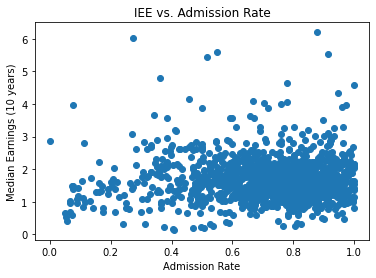

In [12]:
# Set up plot
plt.figure()
plt.title('IEE vs. Admission Rate')
plt.xlabel('Admission Rate')
plt.ylabel('Median Earnings (10 years)')

plt.scatter(inst_level['ADM_RATE'], inst_level['IEE'])

This plot is a decent starting point. It demonstrates two key concepts: (1) most institutions have higher admission rates (>50%) and (2) most low admission rate institutions have low IEEs. This makes sense as institutions that are more selective have more skilled and valuable applicants, and they receive more attention from high-paying companies for recruitment. Admission rate is definitely a good institutional characteristic to investigate further.

### IEE vs. Enrollment

Lastly, we'll plot each institution's IEE and enrollment (student population). Again, a simple scatter plot will do.

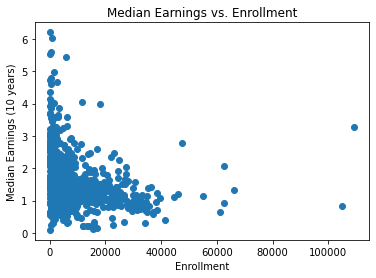

In [13]:
# Set up plot
plt.figure()
plt.title('Median Earnings vs. Enrollment')
plt.xlabel('Enrollment')
plt.ylabel('Median Earnings (10 years)')

plt.scatter(inst_level['UGDS'], inst_level['IEE'])

This plot offers some interesting information. The distribution is unimodal with a distinct upwards skew. It seems that higher enrollment institutions tend to have lower IEEs than lower enrollment institutions. A limitation of this visualization is that we have notion of density at any part of the plot. There is likely many more institutions with low enrollment than high enrollment. Enrollment figures are probably not worth further investigation

## <center>Hypothesis Testing</center>

Now that we know what our attributes look like, we can start to formulate a hypothesis about the data. First, let's rehash some of our preliminary insights, and from there we can begin to hypothesize.

**Insights from Data Exploration**:  
After exploring the data that we have, we've come to the conclusion that the independent variables of interest to our analysis are the control type of the institution and the institution's admission rate. This makes sense logically, as both control type and admission rate are forms of selection or filtration of the enrollment class.

Control type is directly associated with the socio-economic standing of the applicants. Private institutions lack the government support of public institutions and thus rely more heavily on student tuition, resulting in higher student costs. This increase in costs means that private schools need to offer higher earnings after graduation to retain their value.

Admission rate is a reflection of how selective an institution's admissions process when it comes to a heuristic analysis of an applicant's accomplishments. A lower admission rate typically means that a university is in higher demand due to the quality of its education and/or connections. 

**Hypothesis**:  
Let's hypothesize that IEE will get lower with admission rate and that public universities will have lower IEEs than private universities on average.

### Visualizing Hypothesis Variables

Before we can begin fitting statistical models, we need to aggregate the data we've chosen to analyze and decide if any adjustments are needed. Now we will focus on visualizing IEE vs admission rate and control type. Some important python tools we will be using to aggregate data and perform operations on it are statistics and numpy.

In [14]:
import statistics as stat
import numpy as np

To aggregate our data, we'll iterate over our dataframe and collect the IEEs and admission rates of each institution in 1 of 2 lists - 1 for public and 1 for private.

We need to drop any institution that doesn't have admission rate data available, as that data is critical for our analysis. Earlier we mentioned that the two different types of private schools can be homogenized into 1 group, so we will do that now as we aggregate our data.

In [15]:
# Permanently drop any institution that does not have admissions data
print('Before dropping: ' + str(inst_level['UNITID'].count()))
inst_level = inst_level.dropna(subset='ADM_RATE')
print('After dropping: ' + str(inst_level['UNITID'].count()))

# Permanently homogenize public nonprofit and for-profit institutions
for inst in inst_level.iterrows():
    if inst[1]['CONTROL'] == 3:
        inst_level.at[inst[0], 'CONTROL'] = 2

# Collect the IEE and admission rates of public and private institutions in 2 different pairs of parallel arrays.
public_IEE = []
public_ADM = []
private_IEE = []
private_ADM = []
for inst in inst_level.iterrows():
    if inst[1]['CONTROL'] == 1:
        public_IEE.append(inst[1]['IEE'])
        public_ADM.append(inst[1]['ADM_RATE'])
    else:
        private_IEE.append(inst[1]['IEE'])
        private_ADM.append(inst[1]['ADM_RATE'])

Before dropping: 1466
After dropping: 1291


Now let's visualize our data of interest. We'll make 3 IEE vs Admission Rate plots to show the data we want to analyze:
- A plot for public institutions
- A plot for private institutions
- A plot for all institutions together.

Also to make our lives easier, we'll add a horizontal line where the median IEE is for that group.

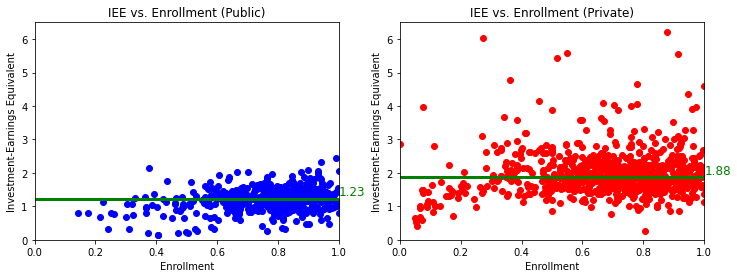

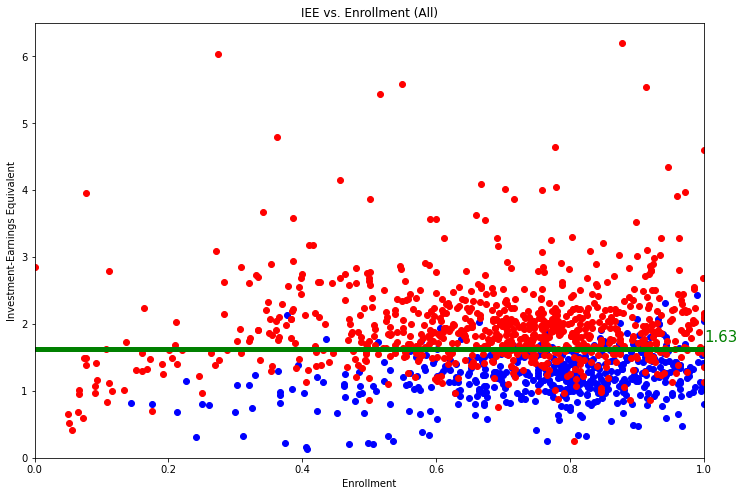

In [16]:
plt.figure(figsize=(12,4))

# Set up public institution plot
ax1 = plt.subplot(1,2,1)
ax1.scatter(public_ADM, public_IEE, color='blue')
ax1.axhline(stat.median(public_IEE), color='green', linewidth=3)
ax1.text(1, stat.median(public_IEE) + 0.1, str(round(stat.median(public_IEE), 2)), color='green', size=12)
ax1.set_title('IEE vs. Enrollment (Public)')
ax1.set_xlabel('Enrollment')
ax1.set_ylabel('Investment-Earnings Equivalent')
ax1.set_ylim([0, 6.5])
ax1.set_xlim([0, 1])

# Set up private institution plot
ax2 = plt.subplot(1,2,2)
ax2.scatter(private_ADM, private_IEE, color='red')
ax2.axhline(stat.median(private_IEE), color='green', linewidth=3)
ax2.text(1, stat.median(private_IEE) + 0.1, str(round(stat.median(private_IEE), 2)), color='green', size=12)
ax2.set_title('IEE vs. Enrollment (Private)')
ax2.set_xlabel('Enrollment')
ax2.set_ylabel('Investment-Earnings Equivalent')
ax2.set_ylim([0, 6.5])
ax2.set_xlim([0, 1])

# Set up all institution plot
plt.figure(figsize=(12,8))
plt.title('IEE vs. Enrollment (All)')
plt.xlabel('Enrollment')
plt.ylabel('Investment-Earnings Equivalent')
plt.ylim([0, 6.5])
plt.xlim([0, 1])
plt.scatter(public_ADM, public_IEE, color='blue')
plt.scatter(private_ADM, private_IEE, color='red')
plt.axhline(stat.median(public_IEE + private_IEE), color='green', linewidth=5)
plt.text(1, stat.median(public_IEE + private_IEE) + 0.1, str(round(stat.median(public_IEE + private_IEE), 2)), color='green', size=15)
print() # Otherwise prints nonsense

The median IEE for public schools is drastically lower than the median IEE for private schools.

These set of plots indicate something about our hypothesis that will need to verified statistically: institution control type is a better a predictor of value than admission rate. Institional value (in terms of IEE) seems to be pretty even across the board for admission rates, which doesn't bode all too well for our hypothesis. This is part of the process, however.

It's clear that the spread of our data is not conducive to a good analysis. There are a small handful of outliers way above the rest of our data that are unique situations that don't reflect the rest of the population. We will use the traditional statistical outlier formulas: $Q1 - 1.5* IQR$ and $Q3 + 1.5 * IQR$ to identify outliers, then we'll remove them and run the above visualization again with the new set of data.

In [17]:
Q3 = np.quantile(inst_level['IEE'], 0.75)
Q1 = np.quantile(inst_level['IEE'], 0.25)
IQR = Q3 - Q1

print('Before removing outliers: ' + str(inst_level['IEE'].count()))
inst_level = inst_level.loc[inst_level['IEE'] < (Q3 + 1.5 * IQR)]
inst_level = inst_level.loc[inst_level['IEE'] > (Q1 - 1.5 * IQR)]
print('After removing outliers: ' + str(inst_level['IEE'].count()))
print('Non-outlier Range: (' + str(Q1 - 1.5 * IQR) + ' , ' + str(Q3 + 1.5 * IQR) + ')')

Before removing outliers: 1291
After removing outliers: 1252
Non-outlier Range: (0.16109890135194171 , 3.1058881998810275)


In [18]:
# Recollect the IEE and admission rates without the outliers.
public_IEE = []
public_ADM = []
private_IEE = []
private_ADM = []
for inst in inst_level.iterrows():
    if inst[1]['CONTROL'] == 1:
        public_IEE.append(inst[1]['IEE'])
        public_ADM.append(inst[1]['ADM_RATE'])
    else:
        private_IEE.append(inst[1]['IEE'])
        private_ADM.append(inst[1]['ADM_RATE'])

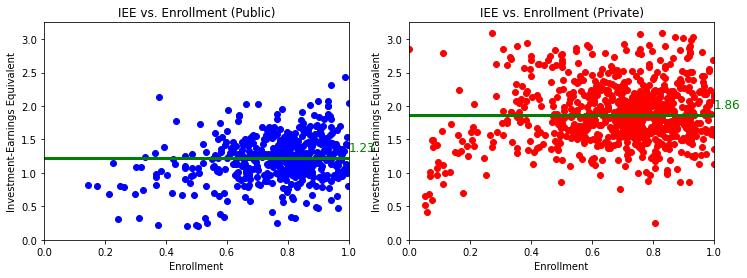

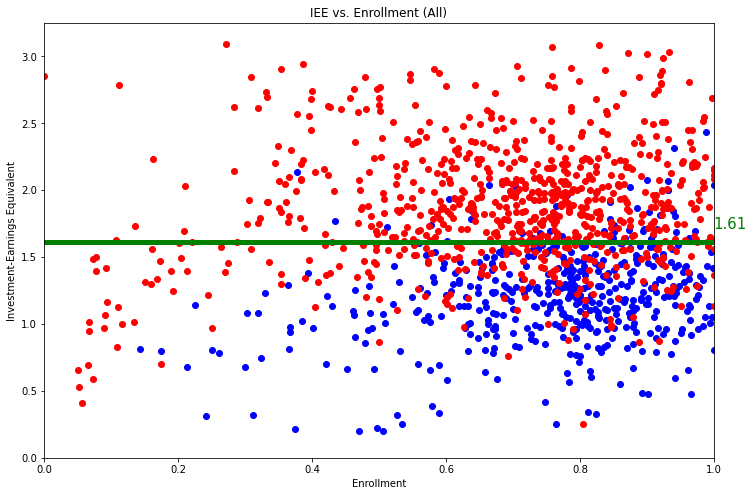

In [19]:
plt.figure(figsize=(12,4))

# Set up public institution plot
ax1 = plt.subplot(1,2,1)
ax1.scatter(public_ADM, public_IEE, color='blue')
ax1.axhline(stat.median(public_IEE), color='green', linewidth=3)
ax1.text(1, stat.median(public_IEE) + 0.1, str(round(stat.median(public_IEE), 2)), color='green', size=12)
ax1.set_title('IEE vs. Enrollment (Public)')
ax1.set_xlabel('Enrollment')
ax1.set_ylabel('Investment-Earnings Equivalent')
ax1.set_ylim([0, 3.25])
ax1.set_xlim([0, 1])

# Set up private institution plot
ax2 = plt.subplot(1,2,2)
ax2.scatter(private_ADM, private_IEE, color='red')
ax2.axhline(stat.median(private_IEE), color='green', linewidth=3)
ax2.text(1, stat.median(private_IEE) + 0.1, str(round(stat.median(private_IEE), 2)), color='green', size=12)
ax2.set_title('IEE vs. Enrollment (Private)')
ax2.set_xlabel('Enrollment')
ax2.set_ylabel('Investment-Earnings Equivalent')
ax2.set_ylim([0, 3.25])
ax2.set_xlim([0, 1])

# Set up all institution plot
plt.figure(figsize=(12,8))
plt.title('IEE vs. Enrollment (All)')
plt.xlabel('Enrollment')
plt.ylabel('Investment-Earnings Equivalent')
plt.ylim([0, 3.25])
plt.xlim([0, 1])
plt.scatter(public_ADM, public_IEE, color='blue')
plt.scatter(private_ADM, private_IEE, color='red')
plt.axhline(stat.median(public_IEE + private_IEE), color='green', linewidth=5)
plt.text(1, stat.median(public_IEE + private_IEE) + 0.1, str(round(stat.median(public_IEE + private_IEE), 2)), color='green', size=15)
print()

### Statistical Modeling & Hypothesis Testing

For this data, we need to produce some sort of regressor because we are predicting a numeric value. Let's start with the simplest regressor - a linear regression model. We will be using statsmodels to perform regressions and retrieve our model's signifiance and predictive power.

In [20]:
import statsmodels.api as sm

/opt/conda/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


#### Simple Linear Regression

The first statistical model we will explore is a basic linear regression. This will simply create a prediction line based on our data. We will be using our overall data, so public and private institutions together.

In [21]:
lm_est = sm.OLS(inst_level['IEE'], sm.add_constant(inst_level['ADM_RATE'])).fit()
print(lm_est.summary())

                            OLS Regression Results                            
Dep. Variable:                    IEE   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7314
Date:                Mon, 16 May 2022   Prob (F-statistic):              0.393
Time:                        03:25:36   Log-Likelihood:                -975.55
No. Observations:                1252   AIC:                             1955.
Df Residuals:                    1250   BIC:                             1965.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5831      0.056     28.232      0.0

This summary has telling information, and rather foreboding for our hypothesis. The p-value for the admission rate variable is 0.393, when the conventional threshold that it should be under to be considered statistically significant is 0.05. Additionally our R^2 value is 0.001, while our goal is to get as close to 1 as possible. In essence, there is no linear relationship between admission rate and IEE.

#### Linear Regression with Interaction Term

Our hypothesis implies a statistical interaction between enrollment and institutional control type. A statistical interaction is a relationship between variables such that 2 or more explanatory (independent) variables influence the outcome of a response (dependent) variable. In this case, both admission rate and control type can influence the IEE of an institution.

To introduce an interaction term into a linear regression, we need to reformat our input data to include the values of all independent variables. In this case, we will create a list with the admission rate of all institutions and control type of institutions encoded as 0 or 1. Then we can feed these pairs into a linear regression model.

In [23]:
# Reformat data for use in an interaction model.
IEEs = []
ADM_controls = []

for (iee, adm) in zip(public_IEE, public_ADM):
    IEEs.append(iee) 
    ADM_controls.append([adm, 0]) # 0 represents public school

for (iee, adm) in zip(private_IEE, private_ADM):
    IEEs.append(iee) 
    ADM_controls.append([adm, 1]) # 1 represents private school

In [24]:
# Fit interaction model using statsmodels. 
lm_int_est = sm.OLS(IEEs, sm.add_constant(ADM_controls)).fit()
print(lm_int_est.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     400.2
Date:                Mon, 16 May 2022   Prob (F-statistic):          4.93e-135
Time:                        03:25:36   Log-Likelihood:                -665.92
No. Observations:                1252   AIC:                             1338.
Df Residuals:                    1249   BIC:                             1353.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9296      0.050     18.768      0.0

The linear interaction model is a drastic improvement over the simple linear model. The p-values are extremely close to 0, meaning the model is statistically significant. The $R^2$ value is 0.391, which isn't great, but still much better than 0.001. An $R^2$ value around 0.4 indicates there is a low correlation between the predictors and the response variable.

#### Simple Polynomial Regression

There's a chance that our data is not linearly distribute. It could benefit us to attempt a higher order regression. To perform polynomial regressions, we will be using sklearn's Polynomial Features. We will use a 2nd degree polynomial, because our data has two 1-dimensional explanatory variables. 

In [32]:
from sklearn.preprocessing import PolynomialFeatures

In [43]:
poly = PolynomialFeatures(degree=2)
xp = poly.fit_transform(np.array(public_ADM + private_ADM).reshape(-1, 1))
pm_est = sm.OLS(IEEs, xp).fit()
print(pm_est.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     6.027
Date:                Mon, 16 May 2022   Prob (F-statistic):            0.00248
Time:                        03:54:45   Log-Likelihood:                -969.91
No. Observations:                1252   AIC:                             1946.
Df Residuals:                    1249   BIC:                             1961.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2819      0.106     12.146      0.0

This simple polynomial regression is better than the simple linear regression because the p-values are below 0.05, so the model is statistically significant. Beyond that however, it's predictive power is next to none because the $R^2$ value is very close to 0.

#### Polynomial Regression with Interaction Term

In [42]:
poly = PolynomialFeatures(degree=2)
xp = poly.fit_transform(ADM_controls)
pm_est = sm.OLS(IEEs, xp).fit()
print(pm_est.pvalues)
print(pm_est.summary())

[3.01444799e-02 3.60364220e-11 9.90189884e-23 2.67738558e-07
 3.70922374e-04 9.90189884e-23]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     212.8
Date:                Mon, 16 May 2022   Prob (F-statistic):          3.23e-139
Time:                        03:54:40   Log-Likelihood:                -650.19
No. Observations:                1252   AIC:                             1310.
Df Residuals:                    1247   BIC:                             1336.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

The polynomial interaction model is the best statistical model we've put together so far. The p-values are all below 0.05, meaning the model is statistically significant. The $R^2$ value is the highest yet at 0.406. Again, $R^2$ values closest to 0.4 indicate a low correlation between the explanatory and response variables.

## <center>Insight Analysis</center>

#### Visualizing Our Statistical Models

Now that we have our statistical models, let's try and see what they look like on our data and glean some insights from them. In order to plot the models, we will need the help of sklearn's LinearRegression, as statsmodels does not provide easily plottable models. Using a different library will not change the results of the models.

In [ ]:
from sklearn.linear_model import LinearRegression

As our basis, we'll plot the all institution data from earlier. On top of it we will plot a few things:
- The simple linear regression (black)
- The linear regression interaction (public: light green, private: cyan)
- The simply polynomial regression (dark green)

Unfortunately, it's not feasible to plot the polynomial interaction model.

0.000584766704797568
[0.37741721 0.6915376 ]
0.390552273905726


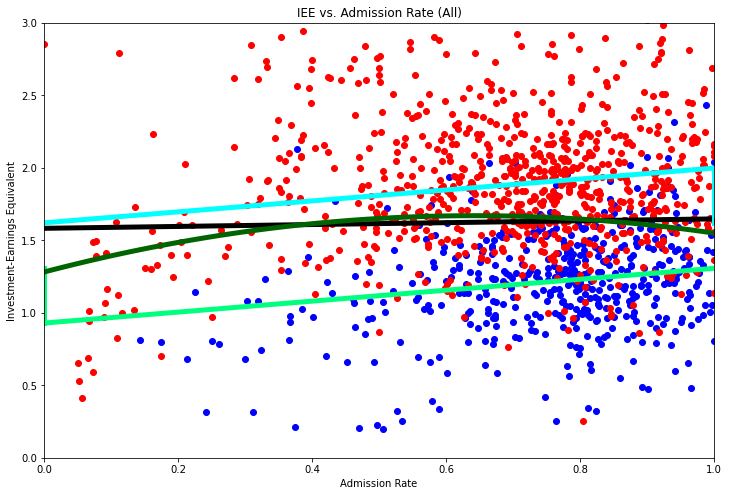

In [53]:
# Set up all institution plot
plt.figure(figsize=(12,8))
plt.title('IEE vs. Admission Rate (All)')
plt.xlabel('Admission Rate')
plt.ylabel('Investment-Earnings Equivalent')
plt.ylim([0, 3])
plt.xlim([0, 1])
plt.scatter(public_ADM, public_IEE, color='blue')
plt.scatter(private_ADM, private_IEE, color='red')

# Fit and plot linear regression for overall data
lm = LinearRegression().fit(np.array(public_ADM + private_ADM).reshape(-1,1), np.array(IEEs).reshape(-1,1))
print(lm.score(np.array(public_ADM + private_ADM).reshape(-1,1), np.array(IEEs).reshape(-1,1)))
plt.plot(np.linspace(0,1,100), lm.predict(np.linspace(0,1,100).reshape(-1,1)), color='black', linewidth=5)

# Fit and plot linear regression lines for each control type based on the interaction
lm = LinearRegression()
lm.fit(ADM_controls, IEEs)
print(lm.coef_)
print(lm.score(ADM_controls, IEEs))
Xs_pub = []
Xs_priv = []
for x in np.linspace(0, 1, 100):
    Xs_pub.append([x, 0])
    Xs_priv.append([x, 1])
plt.plot(Xs_pub, lm.predict(Xs_pub), color='springgreen', linewidth=5)
plt.plot(Xs_priv, lm.predict(Xs_priv), color='aqua', linewidth=5)

# Fit and plot polynomial regression lines for overall data
pm = np.poly1d(np.polyfit(public_ADM + private_ADM, IEEs, 2))
polyline = np.linspace(0, 1, 100)
plt.plot(polyline, pm(polyline), linewidth=5, color = 'darkgreen')

#### Analyzing Our Models

**Simple Linear Regression (black)**:  
This looks awfully similar to the median lines from our earlier plots - and that's why this model has such poor performance. The predictions this model gives are hardly distinguishable from the median. This model is both statistically insignificant and has no predictive power.

**Linear Interaction Regression (light green & cyan)**: 
These two lines seem much more appropriate for the data at hand. This model shows a slight increase in IEE as admission rate increases, and it shows that private institutions generally have higher IEEs than public institutions. I'd like to remind that we found that this model has a low p-value and low $R^2$ value, and I will get to what this means for the model soon.

**Simple Polynomial Regression (dark green)**:  
This model is a bit more descriptive than the simple linear model. It is centered very similarly to the median, but it presents minor nuances of admission rate. Unlike the simple linear regression, this model is statistically significant, meaning it describes a trend in the data that isn't due to variability. Unfortunately, it's atrocious $R^2$ value means it has little predictive power.

**Polynomial Interaction Regression (not visualized)**:
While we cannot see this model visually, we can work from the p-values and $R^2$ values. Like the linear interaction, this model has both a low p-value and low $R^2$ value that I will get to in the following section. 

##### Low P-Value and Low $R^2$ Value?

**Generally Speaking**:  
The way I have been using "low p-value" is to describe any p-value below the standard significance threshold of 0.05. P-values below this threshold indicate the model is statistically significant - the results of the regression cannot be attributed to random chance or variability. There is some sort of pattern in the data causing it to be that way.

A low $R^2$ value, or generally speaking a value around 0.4 means there is a low correlation. In terms of a statistical model, this means that the data being analyzed is only loosely associated for one reason or another.

Putting these two together, it means that the statistical models that we've devised are capable of describing general trends in the data, but cannot accurately predict the response variable given the explanatory variables. 

**For Our Data**:  
In terms of the data we are analyzing, that means that our interaction models can correctly describe a trend that IEE increases with admission rate, and is higher for private institutions. On the other hand however, if we were given an admission rate and control type for a hypothetical institution, our model would struggle to predict its IEE accurately.

## <center>Conclusion and Further Investigation</center>

Choosing an educational institution is incredibly difficult, especially given that it permanently chances the course of your life. This tutorial guided you through an in-depth analysis of university data and there are a few key insights to take away from it:
- Institutions have lower admission rates do tend to offer a better financial value to its students. Going the extra mile to differentiate your application from others with extra curriculars and exemplary academic performance will, on average, lead to a better financial future. This may seem like a no-brainer, but now you have statistical evidence to back up this claim.
- Public institutions offer much better value to its students than private institutions. The smaller enrollment sizes, more lavish amenities, and overall higher sum of resources that private institutions tend to hold simply do not balance out the higher student costs when it comes to earnings. If the quality of your financial investment is paramount to your decision, then go in-state.

There is still plenty of data to explore. The College Scorecard has plenty of data that this brief tutorial could only scratch at the surface. A key point of exploration for the future is the "field of study" data. This dataset holds information about the institutions we analyzed today separated by fields of study. Analysis of this dataset could lead to interesting insights regarding certain fields of study and the value they impart upon their students. Another point of interest for future exploration is income-based value. Data for different income groups is available, meaning it is possible to determine if certain types of institutions are more valuable for some income groups over others.

I hope you that you can walk away from this tutorial having learned something new about data science, python, statistics, or higher education!